In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

In [174]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.hidden_size = hidden_size
        # self.in2in = nn.Linear(input_size, input_size)
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)
    
    def init_states(self, batch_size):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size))
    
    def single_forward(self, x_t, cell_state):
        # x_t = torch.sigmoid(self.in2in(x_t))
        combined = torch.cat((x_t, cell_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return hidden, output
    
    def forward(self, x):
        batch_size, seq_size, _ = x.size()
        outputs = []
        hidden_state = self.init_states(batch_size)
        
        for t in range(seq_size):
            x_t = x[:, t, :]
            hidden_state, output = self.single_forward(x_t, hidden_state)
            outputs.append(output.unsqueeze(0))
            
        outputs = torch.cat(outputs, dim=0)
        outputs = outputs.transpose(0, 1).contiguous()
        outputs = nn.functional.softmax(outputs, dim=-1)
        return outputs

In [159]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_size * 4))
        self.init_weights()
        
        self.hidden2output = nn.Linear(hidden_size, output_size)
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def init_states(self, batch_size):
        return (
            nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size)),
            nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size))
        )
            
    def single_forward(self, x_t, prev_cell_state, prev_hidden_state):
        # batch the computations into a single matrix multiplication
        gates = x_t @ self.W + prev_hidden_state @ self.U + self.bias
        i_t, f_t, g_t, o_t = (
            torch.sigmoid(gates[:, :self.hidden_size]), # input
            torch.sigmoid(gates[:, self.hidden_size:self.hidden_size*2]), # forget
            torch.tanh(gates[:, self.hidden_size*2:self.hidden_size*3]),
            torch.sigmoid(gates[:, self.hidden_size*3:]), # output
        )
        
        cell_state = f_t * prev_cell_state + i_t * g_t
        hidden_state = o_t * torch.tanh(cell_state)
        output = self.hidden2output(hidden_state)
        
        return cell_state, hidden_state, output

    def forward(self, x):
        """ Assumes x is of shape (batch, sequence, feature) """
        batch_size, seq_size, _ = x.size()
        outputs = []
        hidden_state, cell_state = self.init_states(batch_size)
         
        for t in range(seq_size):
            x_t = x[:, t, :]
            cell_state, hidden_state, output = self.single_forward(x_t, cell_state, hidden_state)
            outputs.append(output.unsqueeze(0))
            
        outputs = torch.cat(outputs, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        outputs = outputs.transpose(0, 1).contiguous()
        outputs = nn.functional.softmax(outputs, dim=-1)
        
        return outputs
    

In [160]:
def make_batch(batch_size, seq_length, options=5, easy=True):
    if easy:
        data = torch.zeros((batch_size, seq_length))
    else:    
        data = torch.rand((batch_size, seq_length)) / 2
    first = torch.randint(low=0, high=options, size=(batch_size, 1))
    second = torch.randint(low=0, high=options, size=(batch_size, 1))
    for i in range(batch_size):
        data[i, first[i]] = 1
        data[i, seq_length - second[i] - 1] = 1
        
    data = torch.unsqueeze(data, -1)
    target = (options * first + second).squeeze()
    return data, target

make_batch(2, 16)

(tensor([[[1.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [1.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [1.],
          [0.]]]),
 tensor([ 2, 11]))

Training the models...: 100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 233.93it/s]
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


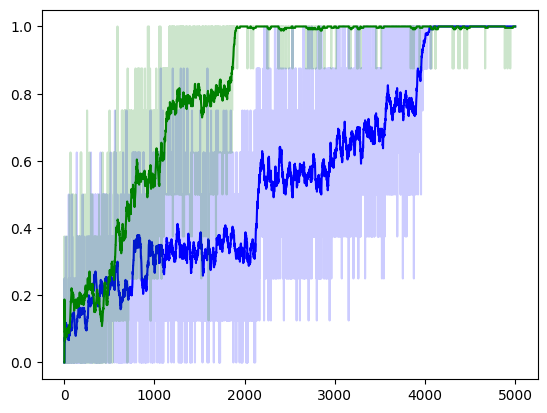

In [196]:
from tqdm import tqdm
easy = True
batch_size = 8
hidden_size = 8
seq_length = 6
options = 3

rnn = CustomRNN(1, hidden_size, options**2)
lstm = CustomLSTM(1, hidden_size, options**2)
num_batches = 5000

rnn_opt = torch.optim.Adam(rnn.parameters(), lr=1e-3)
lstm_opt = torch.optim.Adam(lstm.parameters(), lr=1e-3)
xent_loss = nn.CrossEntropyLoss()
rnn_accs, lstm_accs = [], []

with tqdm(total=num_batches) as pbar:
    pbar.set_description('Training the models...')
    for batch in range(num_batches):
        data, target = make_batch(batch_size, seq_length, options=options, easy=easy)

        rnn_opt.zero_grad()
        rnn_pred = rnn(data)
        rnn_pred = torch.squeeze(rnn_pred)[:, -1]
        rnn_acc = (torch.argmax(rnn_pred, dim=-1) == target).sum() / batch_size
        rnn_loss = xent_loss(rnn_pred, target)
        rnn_loss.backward()
        rnn_opt.step()

        lstm_opt.zero_grad()
        lstm_pred = lstm(data)
        lstm_pred = torch.squeeze(lstm_pred)[:, -1]
        lstm_acc = (torch.argmax(lstm_pred, dim=-1) == target).sum() / batch_size
        lstm_loss = xent_loss(lstm_pred, target)
        lstm_loss.backward()
        lstm_opt.step()

        rnn_accs.append(rnn_acc)
        lstm_accs.append(lstm_acc)
        pbar.update(1)
        
def running_mean(vals, steps=30):
    means = np.zeros_like(vals)
    for i, loss in enumerate(vals):
        if i < steps:
            means[i] = np.mean(vals[:i])
        else:
            means[i] = np.mean(vals[i-steps:i])
    return means
    
plt.plot(np.arange(num_batches), running_mean(rnn_accs), c='b')
plt.plot(np.arange(num_batches), rnn_accs, c='b', alpha=0.2)
plt.plot(np.arange(num_batches), running_mean(lstm_accs), c='g')
plt.plot(np.arange(num_batches), lstm_accs, c='g', alpha=0.2)
plt.show()

# RNN can learn with seq. length of 6 and 3 options
# LSTM can learn with seq. length of 50 and 3 options
# LSTM has difficulty with 'hard' sequences of length > 20

In [195]:
# Let's investigate what the RNN model learned
# Train it with seq. length 6 and 3 options

rnn_process_hidden = [p for p in rnn.in2hidden.parameters()]
rnn_in2hidden_weights = rnn_process_hidden[0].T
rnn_in2hidden_bias = rnn_process_hidden[1].unsqueeze(-1).T

# This is shape [9, 8], since we have a hidden-size of 8 and input size of 1
print(rnn_in2hidden_weights.shape)
print(rnn_in2hidden_bias.shape)

rnn_process_input = rnn_in2hidden_weights[0]
rnn_hidden2hidden = rnn_in2hidden_weights[1:]

print(rnn_process_input.data)


torch.Size([9, 8])
torch.Size([1, 8])
tensor([-3.3734, -1.2419, -2.1469,  1.7632, -4.7211,  0.6966,  3.7377,  3.8433])


In [197]:
# Let's investigate what the RNN model learned
# Train it with seq. length 6 and 3 options

rnn_process_hidden = [p for p in rnn.in2hidden.parameters()]
rnn_in2hidden_weights = rnn_process_hidden[0].T
rnn_in2hidden_bias = rnn_process_hidden[1].unsqueeze(-1).T

# This is shape [9, 8], since we have a hidden-size of 8 and input size of 1
print(rnn_in2hidden_weights.shape)
print(rnn_in2hidden_bias.shape)

rnn_process_input = rnn_in2hidden_weights[0]
rnn_hidden2hidden = rnn_in2hidden_weights[1:]

print(rnn_process_input.data)

torch.Size([9, 8])
torch.Size([1, 8])
tensor([ 3.1614, -1.3885,  3.3220,  3.7652, -2.2039, -4.6691,  0.2675, -1.5014])
